In [10]:
# imports 
import time
import os, sys, glob
import cv2
import math
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch
import gc

from tqdm.auto import tqdm
from PIL import Image, ImageFile
from importlib import reload
from torch.utils.data import DataLoader
from IPython.display import clear_output

# custom imports
sys.path.append('../')

from utils.GetLowestGPU import GetLowestGPU
from utils.GetLR import get_lr
import utils.BuildWNet as BuildWNet
import utils.WNetTileGenerator as TG
import utils.Loss as Loss
import utils.Train as Train
import utils.TrainRec as TrainRec

# get device
device = torch.device(GetLowestGPU(verbose=2))

gc.collect()
torch.cuda.empty_cache()

---------------------------
 GPU | Memory-usage    
---------------------------
  0  | 01264MiB / 40537MiB
  1  | 06226MiB / 40537MiB
  2  | 02046MiB / 40537MiB
  3  | 06226MiB / 40537MiB
  4  | 02036MiB / 40537MiB
  5  | 11202MiB / 40537MiB
  6  | 00003MiB / 40537MiB
  7  | 01264MiB / 40537MiB
---------------------------
 Device set to cuda:6
---------------------------


# Load And Visualize Data

In [11]:
# define paths
image_path = '../data/train/images_by_pod/'

# load images and masks into list
# load image data
image_names = glob.glob(image_path + "*.png")
image_names = [os.path.basename(x) for x in image_names]

n_pad = 128

images = []
# VISUALIZE
for img_name in tqdm(image_names):
    # load image
    image = np.array(Image.open(image_path + img_name))
    image = (image[:, :, :3] / 255.0) # normalize image
    image = np.pad(image, ((n_pad, n_pad), (n_pad, n_pad), (0, 0)), 'edge') # pad image w/ values on edge
    images.append(image)




  0%|          | 0/1127 [00:00<?, ?it/s]

Plotting training examples...


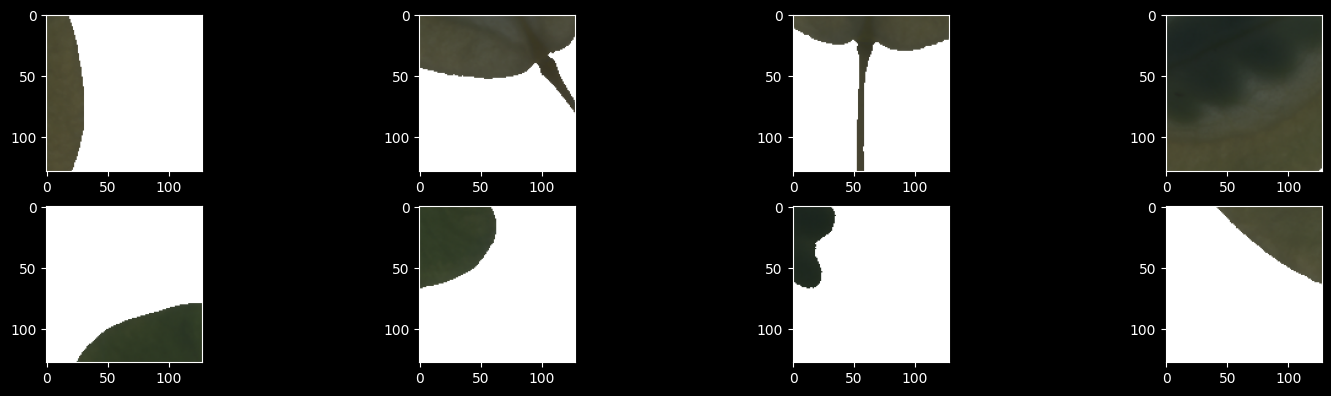

Plotting validation examples...


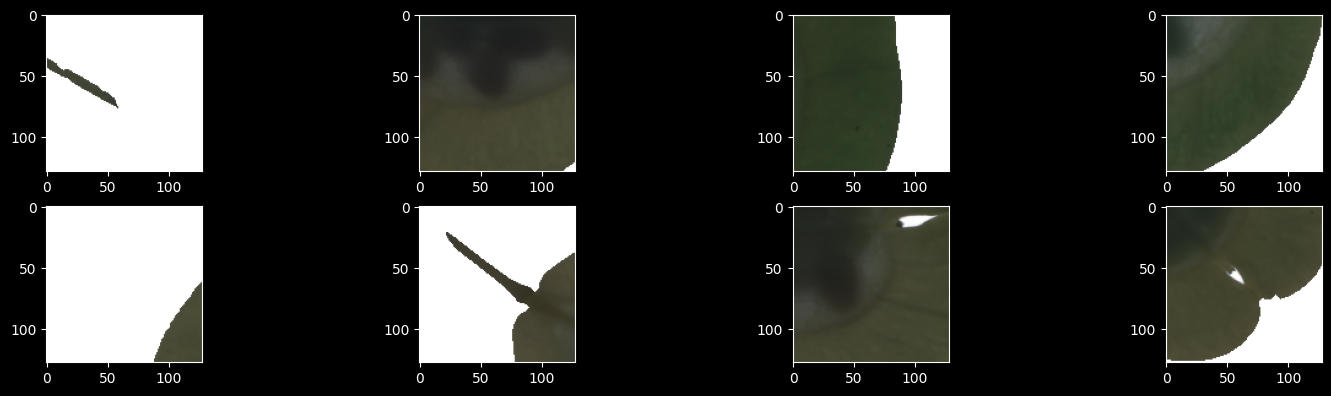

In [12]:
# separate images into train/val set w/ 80-20 split
train_prop = 0.8

#create train/val splits by image
p = np.random.permutation(len(images))
train_idx = p[:int(train_prop*len(images))]
val_idx = p[int(train_prop*len(images)):]

reload(TG)
# instantiate tile generator
train_generator = TG.TileGenerator(images = [images[i] for i in train_idx],
                                   tile_size = 128,
                                   split = 'val',
                                   n_pad = n_pad
                                   )

val_generator = TG.TileGenerator(images = [images[i] for i in val_idx],
                                 tile_size = 128,
                                 split = 'val',
                                 n_pad = n_pad)

#plot random samples
figsize = 15
np.random.seed(0)
    
print('Plotting training examples...')
fig = plt.figure(figsize=(figsize, figsize/2))
N = len(train_generator)
for i in range(8):
    rand_idx = np.random.choice(N)

    img, out = train_generator[rand_idx]
    img = img.permute(1, 2, 0).numpy()
    
    ax = fig.add_subplot(4, 4, i+1)
    plt.imshow(img, vmin=0, vmax=1)

plt.tight_layout(pad=0.5)
plt.show()

print('Plotting validation examples...')
fig = plt.figure(figsize=(figsize, figsize/2))
N = len(val_generator)
for i in range(8):
    rand_idx = np.random.choice(N)

    img, out = val_generator[rand_idx]
    img = img.permute(1, 2, 0).numpy()

    ax = fig.add_subplot(4, 4, i+1)
    plt.imshow(img, vmin=0, vmax=1)

plt.tight_layout(pad=0.5)
plt.show()

# Create Model

In [13]:
# instantiate w-net and optimizer
reload(BuildWNet)
model = BuildWNet.WNet(k = 4).to(device)

# instantiate optimizers
optE = torch.optim.Adam(model.U_encoder.parameters(), lr=1e-3)
optW = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train Model

In [14]:
# options

# log options
log_path = '../logs/log.csv'
chckpnt_path = '../checkpoints/checkpoint_{0}.pt'

# lr options
warmup_iters = 10000
lr_decay_iters = 90000
max_lr = 1e-3
min_lr = 1e-5
max_iters = 150000

In [16]:
reload(Train)
reload(Loss)
Train.train_model(model = model,
                  optimizers = [optE, optW],
                  train_generator = train_generator,
                  val_generator = val_generator,
                  log_path = log_path,
                  chckpnt_path=chckpnt_path,
                  device = device,
                  batch_size=4)

---------------------------------------
Iteration: 19000 | Best Total Loss: 5.7752e-01
---------------------------------------


 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

train N-cut loss: 2.0036e+03, train reconstruction loss: 2.5502e+02
val N-cut loss: 2.0037e+03, val reconstruction loss: 2.6208e+02

validation has not improved in 3 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]